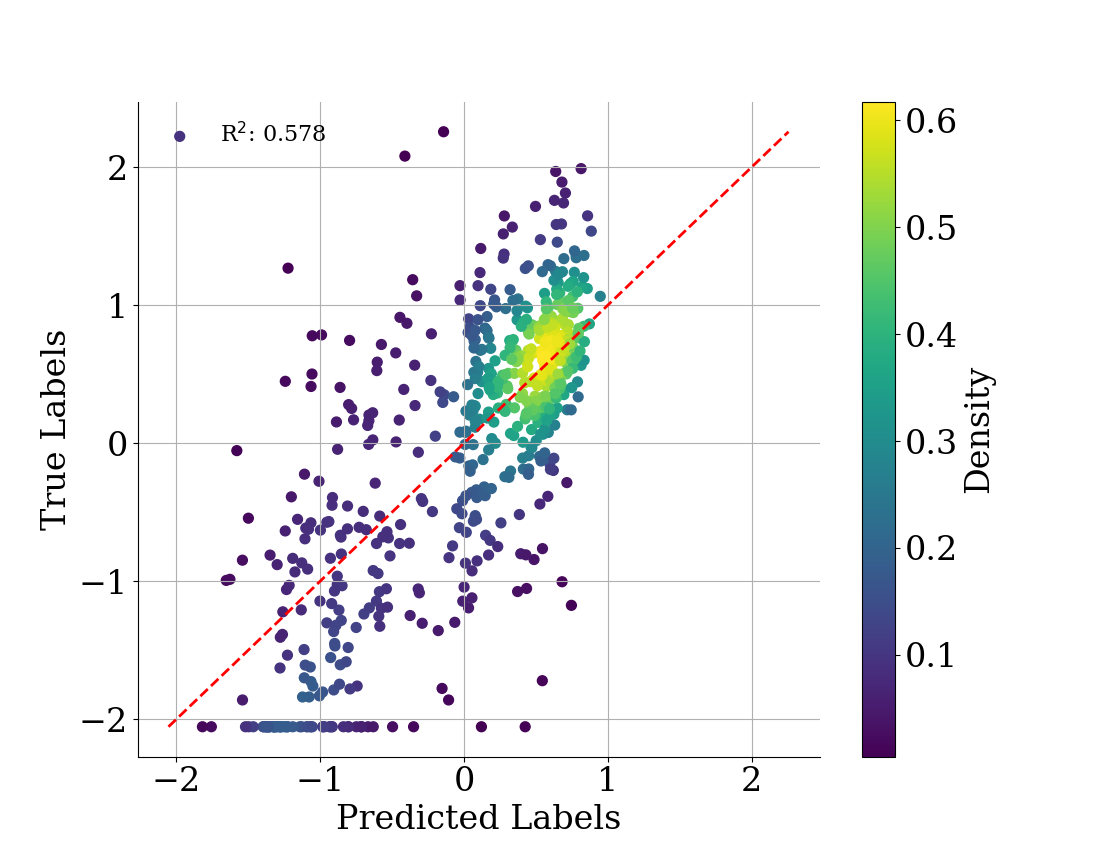

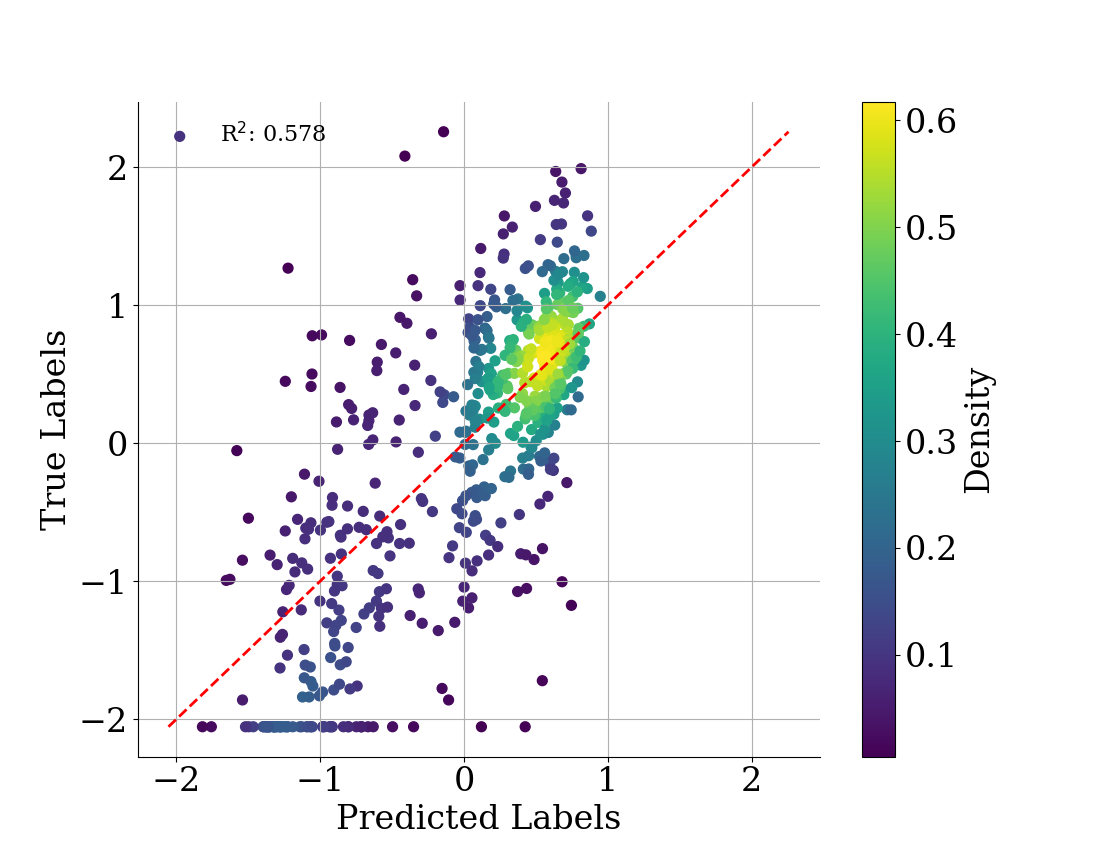
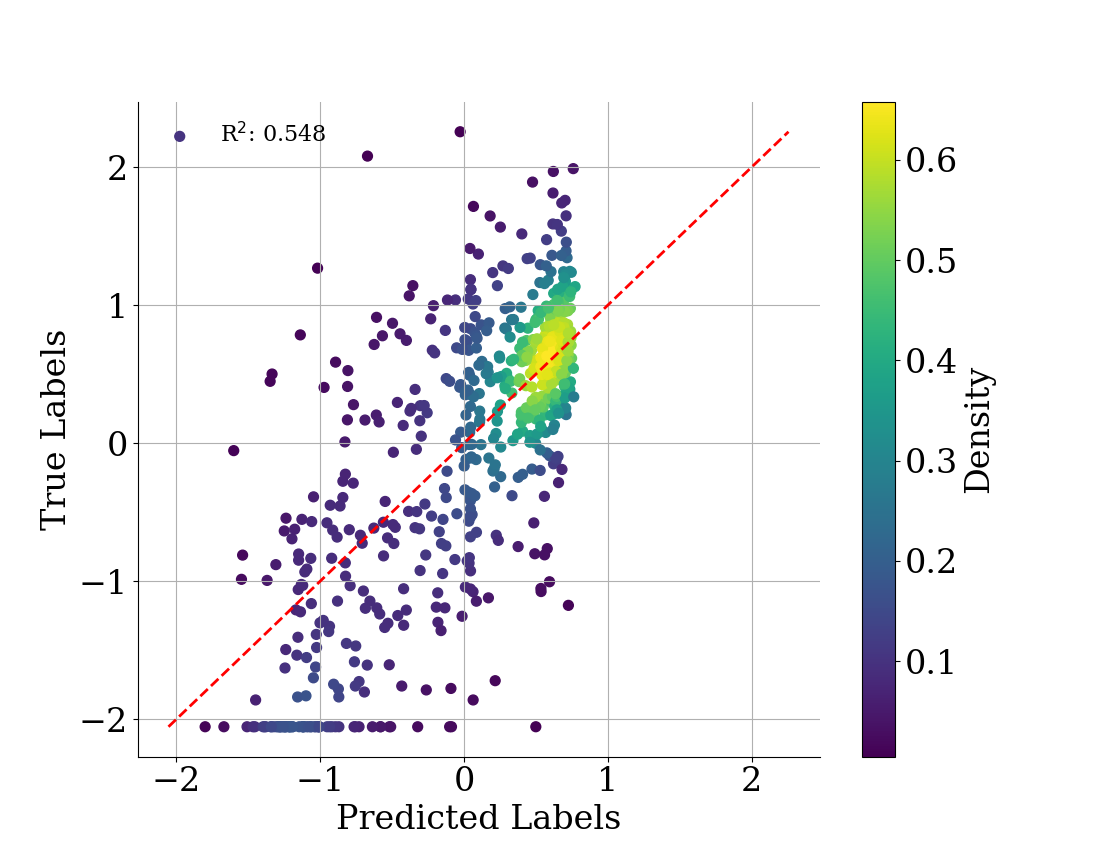

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definizione della classe AttentionPool2d
class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim * embed_dim + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        # x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2]).permute(1, 0)  # N,H,W -> (HW),N

        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0).unsqueeze(-1)  # (HW+1)NC
        pos = self.positional_embedding[:, None, :].to(x.dtype)
        print('x', x.shape)
        print('pos', pos.shape)
        x = x +  pos # Add positional embedding
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0.,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        print('x_final', x.shape)

        return x[:512]

# Parametri 
#dim input-> batch, seq_len, embedded_dim
embed_dim = 128
N, H, W = 2, embed_dim, 1000 # N = batch size, C = numero di canali, H = altezza, W = larghezza
spacial_dim = W  # Supponiamo H e W siano uguali per semplicità

num_heads = 4


# Generazione di un batch di immagini di esempio
images = torch.randn(N, H, W).to(device='cuda')
print(images.shape)

# Inizializzazione dell'Attention Pooling
attention_pool = AttentionPool2d(spacial_dim, embed_dim, num_heads).to(device='cuda')

# Applicazione dell'Attention Pooling
pooled_features = attention_pool(images)

# Stampa delle dimensioni dell'output
print(f"Dimensioni dell'output: {pooled_features.shape}")